# 3 Feature Generation - Technical Analysis

This notebook explores technical analysis for feature generation and the various libraries used to generate technical indicators. There are also various proprietary indicators implemented by hand from theories on websites such as investing.com in which various MQL4 scripts have been interpreted to produce bespoke features.

In [288]:
#Library imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

from sklearn.preprocessing import StandardScaler

#Technical Indicator Libraries
import talib as ta
import pandas_ta as new_ta

import seaborn as sns

import math
#Import for data visualisation
from sklearn.metrics import plot_confusion_matrix

#Import K-NN Clasiffer and methods for splitting training/test data + score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from IPython.display import clear_output
from sklearn.feature_selection import RFE


from pylab import rcParams

## 3.1 Load AUD/USD Dataset

Features will be generated for the AUD/USD dataset between 2011-2019

In [289]:
#read dataset in
df = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")

#index by date and remove duplicates
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

df['Date'] = pd.DataFrame(df.Date).applymap(lambda x: x.date())

df = df.set_index(df.Date)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

#remove 0 volume days
df = df[df['Volume'] != 0]

df

,Open,High,Low,Close,Volume
Date,,,,,
2011-01-02,1.02070,1.02267,1.01582,1.01687,69778.4109
2011-01-03,1.01687,1.01716,1.00294,1.00517,124906.5397
2011-01-04,1.00517,1.00770,0.99613,0.99961,119343.0942
2011-01-05,0.99961,1.00159,0.99338,0.99449,99106.5343
2011-01-06,0.99448,0.99932,0.99087,0.99614,101413.4171
...,...,...,...,...,...
2018-12-25,0.70428,0.70723,0.70333,0.70693,77848.7096
2018-12-26,0.70693,0.70786,0.70173,0.70352,193196.9914
2018-12-27,0.70338,0.70698,0.70287,0.70412,147956.1087


## 3.2 Manually Implementing Technical Indicators

Due to the sheer amount of technical indicators being implemented for the Forex market by retail traders daily, it would be naive not to use them. In this section, a range of indicators were manually implemented by interpreting theories and MQL4 scripts of indicators described on tradingview.com

In [290]:
#SSL Indicator Function
def ssl_channel_indicator(df, period = 20):
    
    df['SMA_High'] = ta.SMA(df.High, timeperiod=period)
    
    df['SMA_Low'] = ta.SMA(df.Low, timeperiod=period)
    
    hlv = pd.DataFrame(columns=['HLV'], index=df.index)
    
    sslDown = pd.DataFrame(columns=['SSL_Down'], index=df.index)
    
    sslUp = pd.DataFrame(columns=['SSL_Up'], index=df.index)
    
    for i in range(0,len(df.Close)):
        
        if df.Close.iloc[i] > df.SMA_High.iloc[i]:
            
            hlv.iloc[i] = 1
            
        elif df.Close.iloc[i] < df.SMA_Low.iloc[i]:
            
            hlv.iloc[i] = -1
            
        else:
            
            hlv.iloc[i] = hlv.iloc[i-1]
            
    for i in range(0,len(hlv)):
        
        if hlv.HLV.iloc[i] <= 0:
            
            sslDown.iloc[i] = df.SMA_High.iloc[i]
            
        else:
            
            sslDown.iloc[i] = df.SMA_Low.iloc[i]
            
    for i in range(0,len(hlv)):
        
        if hlv.HLV.iloc[i] < 0:
            
            sslUp.iloc[i] = df.SMA_Low.iloc[i]
            
        else:
            
            sslUp.iloc[i] = df.SMA_High.iloc[i]     
    
    return sslDown, sslUp

#ATR Indicator Function
def atr_indicator(df, period = 13):
    
    atr = new_ta.atr(df.High, df.Low, df.Close, period)

    return atr

#Linear WMA Indicaotr Function
def lwma_indicator(df, period=15):
        
    lwma = pd.DataFrame(columns=['LWMA'], index=df.index)
    
    for i in range(0,len(df)):
        
        if i < (period-1):
            
            continue
        
        else:
            
            sum_prices = 0
    
            for j in range(0,period+1):
            
                price = df.Close.iloc[i-j]
                
                sum_prices += (price * (period-j))
                
            lwma.iloc[i] = sum_prices/(np.sum(range(1,period+1)))
        
    return lwma

#QQE indicators function - similar to RSI indicator (shows trend strength signal)
def qqe_indicator(df, period=10):
    
    qqe = new_ta.qqe(df.Close, length=period)
    
    qqe.columns = ['QQE','RSI','Long','Short']

    qqe = qqe.reset_index().drop(columns=['Long','Short'])
    
    QQE = qqe['QQE']

    RSI = qqe['RSI']
    
    return QQE.values, RSI.values

#Volatility Index Indicator
def volatility_index_indicator(df, period=10):
    
    volatility = pd.DataFrame(columns=['VOLATILITY'], index=df.index)
    
    for i in reversed(range(0,len(df)-1)):
        
        if df.Close.iloc[i] > df.Open.iloc[i]:
            
            volatility.iloc[i] = abs(df.High.iloc[i] - df.Low.iloc[i+1])
        
        elif df.Close.iloc[i] < df.Open.iloc[i]:
            
            volatility.iloc[i] = abs(df.Low.iloc[i] - df.High.iloc[i+1])
            
        else:
            
            volatility.iloc[i] = volatility.iloc[i+1]
        
    volatility = ta.SMA(volatility.VOLATILITY, timeperiod=5)
    
    sma_vol = ta.SMA(volatility, timeperiod=15)
            
    return volatility, sma_vol

## 3.3 Extracting Technical Indicators

The principal form of technical analysis came from the pandas_ta and talib library which provided convenient methods for calculations. Here, a range of volume, momentum, volatility and strength indicators are engineered.

In [291]:
#Function to generate technical analysis features
def technical_analysis(df, period):
    
    df['Adj_Close'] = (df.High + df.Low)/2
    
    df['Return'] = df.Close.pct_change(1)
    
    df['Label'] = pd.DataFrame(df.Return.shift(-1)).applymap(lambda x: 1 if x > 0 else -1)
    
    #volatility indicators
    df['ATR'] = ta.ATR(df.High, df.Low, df.Close, timeperiod=10)
    
    #momentum indicators
    df['ADX'] = ta.ADX(df.High, df.Low, df.Close, timeperiod=10)
    
    df['AROON_Down'], df['AROON_Up'] = ta.AROON(df.High, df.Low, timeperiod = 10)
    
    df['CCI'] = ta.CCI(df.High, df.Low, df.Close, timeperiod = 10)
    
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = ta.MACD(df.Close, fastperiod=15, slowperiod=30)
    
    df['PROC12'] = ta.ROC(df.Close, timeperiod = 12)
    
    df['PROC13'] = ta.ROC(df.Close, timeperiod = 13)
    
    df['PROC14'] = ta.ROC(df.Close, timeperiod = 14)
    
    df['PROC15'] = ta.ROC(df.Close, timeperiod = 15)
    
    df['W%R6'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=6)
    
    df['W%R7'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=7)

    df['W%R8'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=8)

    df['W%R9'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=9)

    df['W%R10'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=10)

    df['STOCH_K5'], df['STOCH_D5'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=5)
    
    df['STOCH_K8'], df['STOCH_D8'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=8)

    df['STOCH_K10'], df['STOCH_D10'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=10)
    
    df['MOM3'] = ta.MOM(df.Close, timeperiod=3)
    
    df['MOM5'] = ta.MOM(df.Close, timeperiod=5)
    
    df['MOM8'] = ta.MOM(df.Close, timeperiod=8)
    
    df['MOM9'] = ta.MOM(df.Close, timeperiod=9)
    
    df['MOM10'] = ta.MOM(df.Close, timeperiod=10)
    
    df['BB_High'], df['BB_Mid'], df['BB_Low'] = ta.BBANDS(df.Close, timeperiod=15)

    df['DEMA10'] = ta.DEMA(df.Close, timeperiod=10)
    
    df['DEMA15'] = ta.DEMA(df.Close, timeperiod=15)
    
    df['SMA10'] = ta.SMA(df.Close, timeperiod=10)
    
    df['SMA15'] = ta.SMA(df.Close, timeperiod=15)
    
    df['EMA10'] = ta.EMA(df.Close, timeperiod=10)
    
    df['EMA15'] = ta.EMA(df.Close, timeperiod=15)
    
    df['SAR'] = ta.SAR(df.High, df.Low)
    
    df['ADOSC1'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=2, slowperiod=10)
    
    df['ADOSC2'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=3, slowperiod=10)

    df['ADOSC3'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=4, slowperiod=10)

    df['ADOSC4'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=5, slowperiod=10)

    df['ADOSC5'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=6, slowperiod=10)

    df['SSL_Down'], df['SSL_Up'] = ssl_channel_indicator(df)
    
    df['RSI10'] = ta.RSI(df.Close, timeperiod=10)
    
    df['RSI15'] = ta.RSI(df.Close, timeperiod=15)
    
    df['KAMA15'] = ta.KAMA(df.Close, timeperiod=15)
    
    df['KAMA30'] = ta.KAMA(df.Close, timeperiod=30)
    
    df['Return'] = df.Close.pct_change()

    df['SSL_Down'], df['SSL_Up'] = ssl_channel_indicator(df)

    df['ATR'] = atr_indicator(df, period=13)

    df['LWMA'] = lwma_indicator(df, period=10)

    df['QQE'], df['RSI_MA'] = qqe_indicator(df, period=13)

    df['VOLA'], df['SMA_VOLA'] = volatility_index_indicator(df, period=13)
    
    return df
    
data = df.copy()
data = technical_analysis(data, 5)

In [292]:
data = data.fillna(method='bfill')
data = data.fillna(method='ffill')

data

,Open,High,Low,Close,Volume,Adj_Close,Return,Label,ATR,ADX,...,SSL_Up,RSI10,RSI15,KAMA15,KAMA30,LWMA,QQE,RSI_MA,VOLA,SMA_VOLA
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-02,1.02070,1.02267,1.01582,1.01687,69778.4109,1.019245,-0.011506,-1,0.011282,40.959350,...,1.001981,29.647266,39.009429,0.990282,1.004501,0.994766,47.900429,33.588341,0.005684,0.010457
2011-01-03,1.01687,1.01716,1.00294,1.00517,124906.5397,1.010050,-0.011506,-1,0.011282,40.959350,...,1.001981,29.647266,39.009429,0.990282,1.004501,0.994766,47.900429,33.588341,0.005684,0.010457
2011-01-04,1.00517,1.00770,0.99613,0.99961,119343.0942,1.001915,-0.005531,-1,0.011282,40.959350,...,1.001981,29.647266,39.009429,0.990282,1.004501,0.994766,47.900429,33.588341,0.005684,0.010457
2011-01-05,0.99961,1.00159,0.99338,0.99449,99106.5343,0.997485,-0.005122,1,0.011282,40.959350,...,1.001981,29.647266,39.009429,0.990282,1.004501,0.994766,47.900429,33.588341,0.005684,0.010457
2011-01-06,0.99448,0.99932,0.99087,0.99614,101413.4171,0.995095,0.001659,-1,0.011282,40.959350,...,1.001981,29.647266,39.009429,0.990282,1.004501,0.994766,47.900429,33.588341,0.005684,0.010457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,0.70428,0.70723,0.70333,0.70693,77848.7096,0.705280,0.003848,-1,0.005705,35.885157,...,0.717411,34.420872,37.699265,0.711604,0.721906,0.708881,40.708379,34.656866,0.005544,0.005088
2018-12-26,0.70693,0.70786,0.70173,0.70352,193196.9914,0.704795,-0.004824,1,0.005738,38.039262,...,0.716019,30.526674,34.886172,0.710517,0.721016,0.707337,40.708379,34.194887,0.004248,0.005039
2018-12-27,0.70338,0.70698,0.70287,0.70412,147956.1087,0.704925,0.000853,1,0.005613,39.977957,...,0.714737,32.030050,35.789442,0.709844,0.719843,0.706255,40.708379,34.247754,0.004222,0.005094


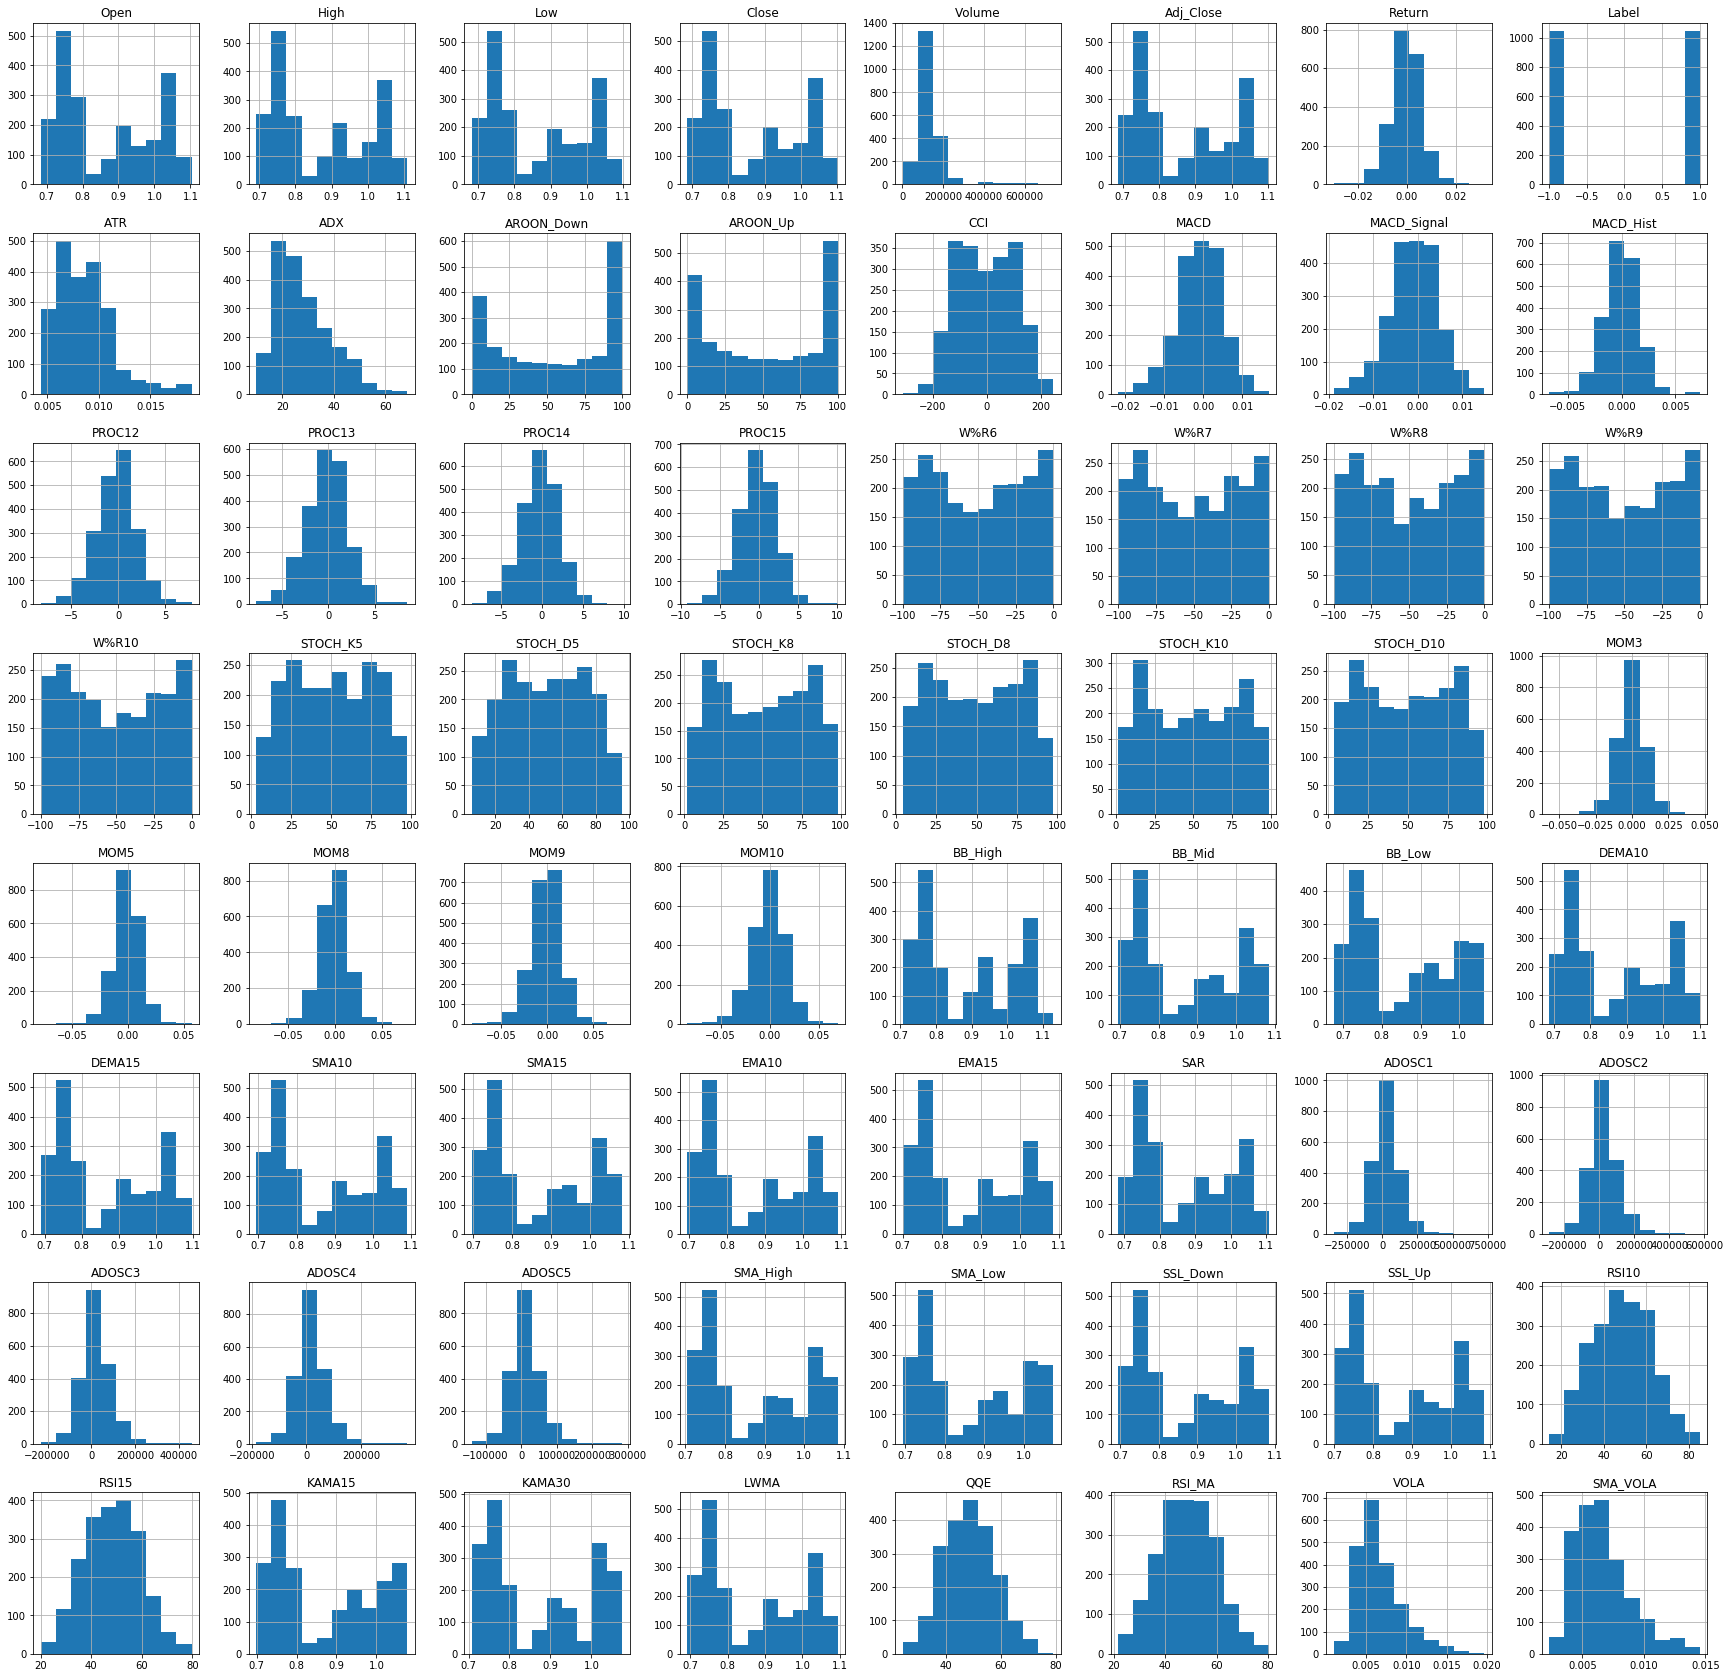

In [293]:
data.hist(figsize=(30,30));

## 3.4 Visualising Indicators

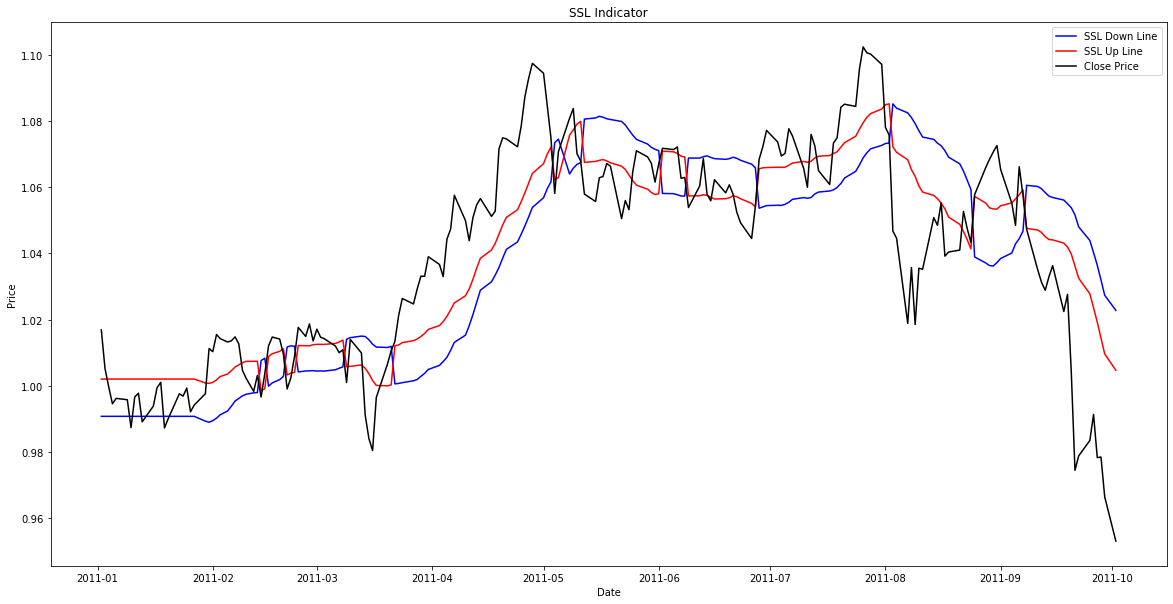

In [266]:
#plot ssl indicator
def plot_ssl(df):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_ylabel("Price")
    ax.set_xlabel("Date")
    ax.set_title("SSL Indicator")
    ax.plot(df.SSL_Down[:200], c='b', label="SSL Down Line")
    ax.plot(df.SSL_Up[:200], c='r', label="SSL Up Line")
    ax.plot(df.Close[:200], c='black', label="Close Price")
    plt.legend()
    
plot_ssl(data)

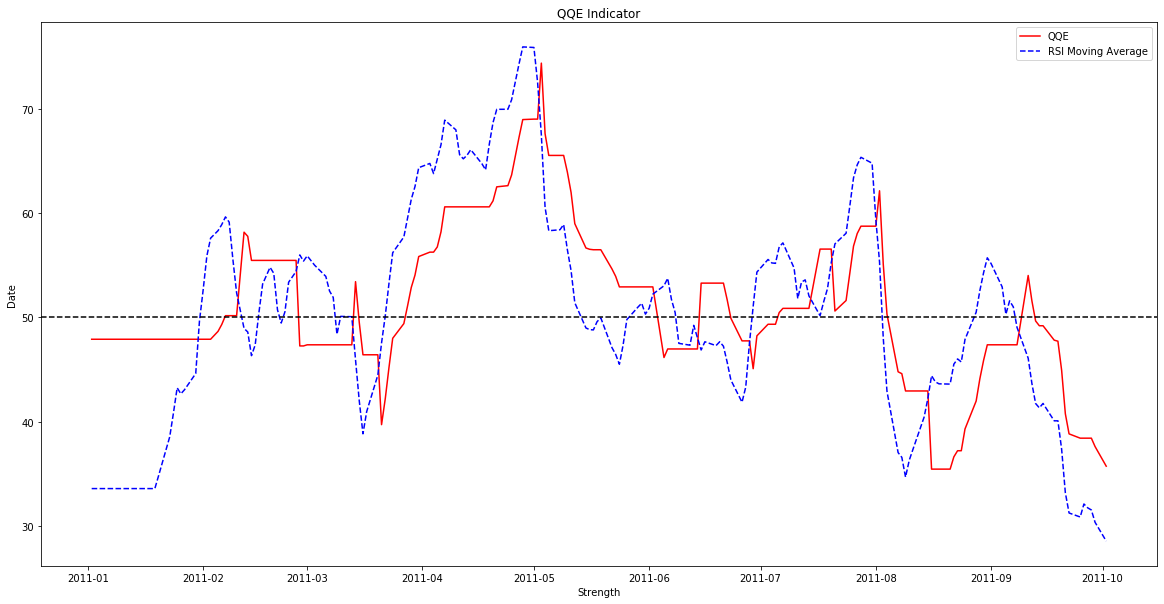

In [267]:
#plot qqe indicator
def plot_qqe(df):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(df.QQE[:200], c='red', label="QQE")
    ax.plot(df.RSI_MA[:200], c='blue', linestyle='--', label='RSI Moving Average')
    ax.axhline(y=50, c='black', linestyle='--')

    ax.set_title("QQE Indicator")
    ax.set_xlabel("Strength")
    ax.set_ylabel("Date")
    ax.legend()
    
plot_qqe(data)

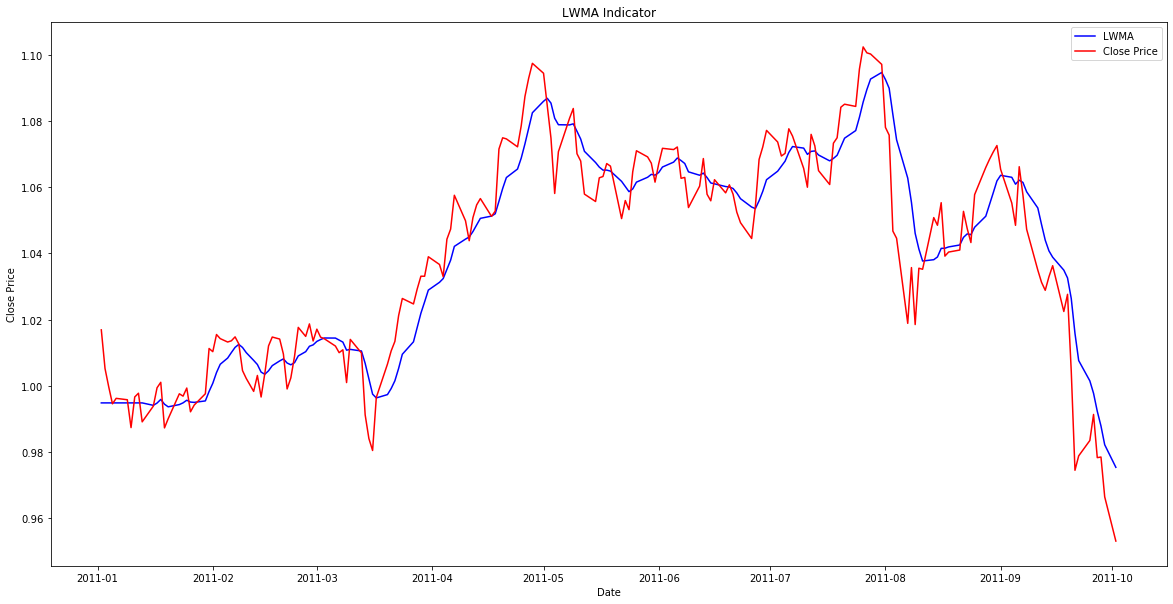

In [268]:
#plot LWMA indicator
def plot_lwma(df):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(df.LWMA[:200], c='b', label='LWMA')
    ax.plot(df.Close[:200], c='r', label='Close Price')
    ax.legend()
    
    ax.set_title("LWMA Indicator")
    ax.set_ylabel("Close Price")
    ax.set_xlabel("Date")
    
plot_lwma(data)

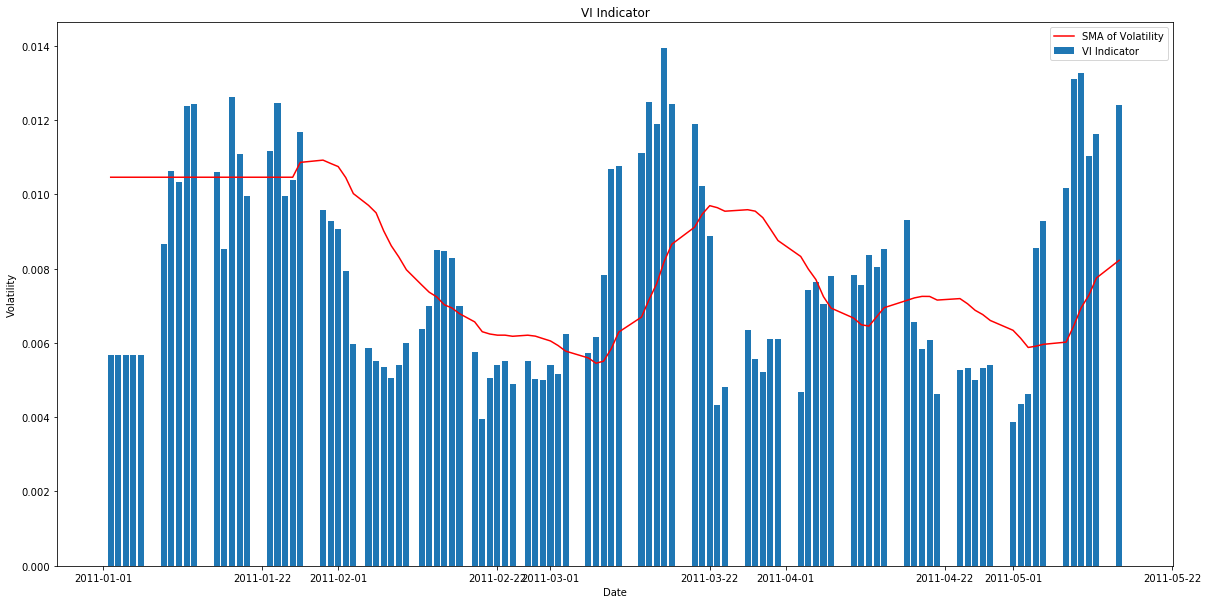

In [269]:
#plot VI indicator
def plot_vi(df):
    fig = plt.figure(figsize=(20,10))
    
    ax = fig.gca()
    
    ax.set_ylabel("Volatility")
    ax.set_xlabel("Date")
    ax.set_title("VI Indicator")
    
    ax.bar(df.index[0:100], df.VOLA[0:100], label='VI Indicator')
    ax.plot(df.index[0:100], df.SMA_VOLA[0:100], c='red', label='SMA of Volatility')
    ax.legend()

plot_vi(data)

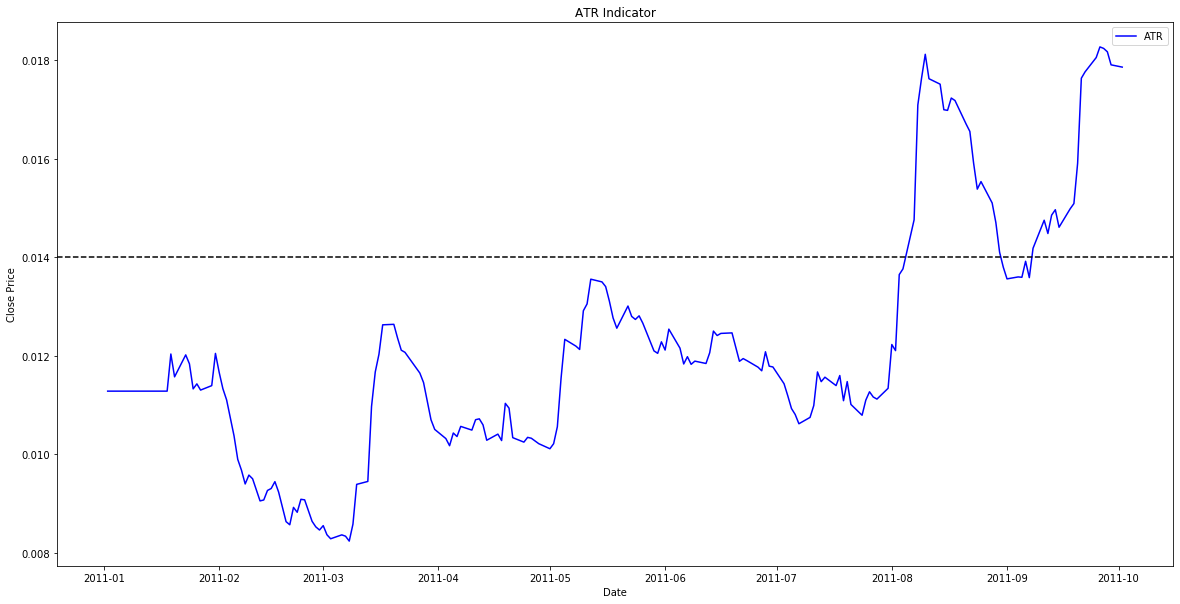

In [270]:
#plot Average True Range (ATR)
def plot_atr(df):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.plot(df.ATR[:200], c='b', label='ATR')
    ax.axhline(y=0.014, c='black', linestyle='--')
    ax.legend()
    
    ax.set_title("ATR Indicator")
    ax.set_ylabel("Close Price")
    ax.set_xlabel("Date")

plot_atr(data)

## 3.5 Testing Technical Data with Random Forest classifier

The full technical analysis dataset was tested on a RF classifier to establish how well technical indicators could classify next day trends in the AUD/USD dataset. The Random Forest was used to minimise pre-processing requirements for rapid results and analysis.

In [271]:
def rf_model(data, labels):
    #generate training data and split
    X = data.copy().drop(columns=['Label','Return','Open','High','Low','Close','Volume'])
    y = labels.values.astype(int)
    
    split = int(len(X)*0.8)

    X_train = X[0:split]
    X_test = X[split+1:]
    
    y_train = y[0:split]
    y_test = y[split+1:]

    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)

    score = cross_val_score(rf,X_train,y_train)
    
    print("The cross validation score for Technical Analysis data is", rf.score(X_test,y_test))
    
    initial = 1000
    for i in range(0,len(y_test)):
        initial = initial + data.Close[split+i+1] * predicted[i]
    print("Total Equity if trading from daily predictions on test data (initial equity = 1000):", initial)
    
    #Plot confusion matrices
    titles_options = [("Confusion matrix, without normalization", None)]

    disp = plot_confusion_matrix(rf, X_test, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues)

    disp.ax_.set_title("Confusion Matrix")
    
    return score

In [272]:
data.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
           ..
LWMA        0
QQE         0
RSI_MA      0
VOLA        0
SMA_VOLA    0
Length: 64, dtype: int64

In [273]:
data.Label.value_counts()

-1    1048
 1    1043
Name: Label, dtype: int64

The cross validation score for Technical Analysis data is 0.5167464114832536
Total Equity if trading from daily predictions on test data (initial equity = 1000): 1046.4932800000004


array([0.52835821, 0.48955224, 0.52095808, 0.40718563, 0.47005988])

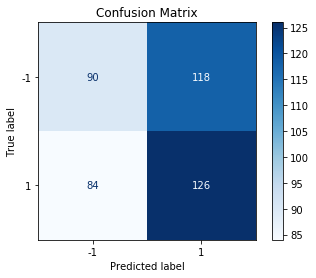

In [287]:
#test random forest model
rf_model(data, data.Label)

It can be observed that the unoptimized model struggles to identify next day trends in the AUD/USD dataset by the random walk equivalent classification accuracy. There appears to be a strong positive bias for predictions and implies that further abstractions of data and feature generation techniques are required as well as feature selection and broader evaluation metrics.